In [24]:
import numpy as np # Dizi ve matris işlemleri için özelleşmiş bir kütüphanedir.
import matplotlib.pyplot as plt #Grafikleştirme işlemleri için kullanılan kütüphanedir.
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
#Eğitim öncesi görüntü ayarlarını yapmak için kullanılır.
#Görüntü artırma, ölçeklendirme gibi işlemler.

In [25]:
import glob, os#dosya işlemleri için kullanılan kütüphanelerdir.
import random 

## Verisetinin yüklenmesi

In [26]:
#Dosya yolu
base_path = r"C:\Users\Turan\Desktop\DerinOgrenme\TezCalismalari\veriseti\Garbage classification\garbage classification\Garbage classification"
#dosyadan okunan fotoğrafların yüklendiği değişken
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))#okunan fotoğraf sayısı

2527


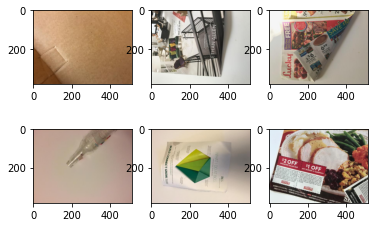

In [27]:
#Verisetinden örnek bir kaç görüntü
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

## Veri setinin modelin girişine hazırlanması ve bölünmesi

In [43]:
train_datagen = ImageDataGenerator(validation_split=0.3,#Veri setini bölme oranı
                                   preprocessing_function=preprocess_input)#Görüntü ön işlemi
#rescale = 1./255 kullanmak bu model için elverişsiz oluyor.

train_generator = train_datagen.flow_from_directory(base_path,
                                                     target_size=(224,224),#Fotoğrafın kaça kaç olacağı
                                                     batch_size=32,
                                                     shuffle=True,
                                                     class_mode='categorical',#Sınıfların sırasını kontrol etmek için kullanılır
                                                     subset='training')#Alt küme ayarlama validation/training

validation_datagen = ImageDataGenerator(validation_split=0.3,
                                        preprocessing_function=preprocess_input)

validation_generator =  validation_datagen.flow_from_directory(base_path,
                                                                target_size=(224,224),
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                subset='validation')  

Found 1771 images belonging to 6 classes.
Found 756 images belonging to 6 classes.


## Derin öğrenme Kütüphanelerinin yüklenmesi

In [44]:
from keras.applications import ResNet50 
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense

## ResNet50 Modelinin yüklenmesi

In [45]:
base_model = ResNet50(weights='imagenet',#İmageNet'in ağırlıklarını yükler.
                      include_top=False, 
                      input_shape=(224, 224, 3))#Görüntünün giriş boyutu
base_model.trainable = False

In [46]:
from keras.models import Sequential#Model oluşturmayı sağlar.
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
#Konvolüsyon,Flatten(Düzleştirme),Havuzlama(MAX),Dropout ve Normal katmanların kullanımını sağlar.

model = Sequential([#Model oluşturma
    base_model,#Giriş modeli (Functional)
    GlobalAveragePooling2D(),#Havuzlama Katmanı
    Dropout(0.15),
    Dense(1024, activation='relu'),#Tam bağlı katman
    Dense(6, activation='softmax')#Çıkış katmanı
])

## Modeli derleme

In [47]:
from keras import optimizers, losses #Optimizasyon ve kayıp fonksiyonlarının kullanımını sağlar.

opt = optimizers.Adam(lr=0.0001)#Optimizasyon için Adam fonksiyonu seçildi ve learning rate 0.0001 olarak belirlendi.
model.compile(#Model derleme işlemleri. 
    loss="categorical_crossentropy",#Kayıp fonksiyonu
              optimizer=opt, #Optimizyon fonksiyonu
              metrics=['accuracy']) #Doğruluk ölçütü-değeri


In [48]:
model.summary()#model özeti

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 6150      
Total params: 25,692,038
Trainable params: 2,104,326
Non-trainable params: 23,587,712
_________________________________________________________________


In [49]:
batch_size = 32 #Bir seferde verilecek veri yığını boyutu
epochs = 100 #iterasyon sayısı

In [50]:
#bir iterasyonda verilecek train ve test verilerinin oranlanması
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

## Early Stopping ve Model Checkpoint

In [51]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


filepath = "model_resnet50_{epoch:02d}-{val_accuracy:.2f}.h5"#Kaydedilecek modelin adı
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)#Aşırı öğrenmeyi önlemek için kullanılır.
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#Modelin test verisi üzerinde başarısı her arttığında kaydetme işlemini yapar.
callbacks_list = [es, checkpoint1]#Eğitime verilmek için liste haline getirildi.

## modeli eğitme

In [52]:
history = model.fit_generator(
    generator=train_generator, #Eğitim verisi
    epochs=epochs, #iterasyon sayısı
    steps_per_epoch=steps_per_epoch, 
    validation_data=validation_generator,#Test verisi
    validation_steps=validation_steps,
    callbacks=callbacks_list#Early stopping ve model checkpoint değerleri
)

Epoch 1/100
55/55 [==============================] - 25s 392ms/step - loss: 1.0983 - accuracy: 0.6029 - val_loss: 0.6728 - val_accuracy: 0.7554

Epoch 00001: val_accuracy improved from -inf to 0.75543, saving model to model_resnet50_01-0.76.h5
Epoch 2/100
55/55 [==============================] - 20s 365ms/step - loss: 0.3478 - accuracy: 0.8914 - val_loss: 0.5972 - val_accuracy: 0.7799

Epoch 00002: val_accuracy improved from 0.75543 to 0.77989, saving model to model_resnet50_02-0.78.h5
Epoch 3/100
55/55 [==============================] - 20s 367ms/step - loss: 0.2367 - accuracy: 0.9293 - val_loss: 0.5426 - val_accuracy: 0.8016

Epoch 00003: val_accuracy improved from 0.77989 to 0.80163, saving model to model_resnet50_03-0.80.h5
Epoch 4/100
55/55 [==============================] - 20s 368ms/step - loss: 0.1722 - accuracy: 0.9463 - val_loss: 0.5121 - val_accuracy: 0.8125

Epoch 00004: val_accuracy improved from 0.80163 to 0.81250, saving model to model_resnet50_04-0.81.h5
Epoch 5/100
55/

## Sonuç skoru

In [53]:
score = model.evaluate(validation_generator,batch_size=32)#Modeli test verisi ile dener.
score
print('Score Accuracy : {:.2f}%'.format(score[1]*100))#Sonucu yüzdeye uyarlar.

24/24 [==============================] - 7s 283ms/step - loss: 0.6168 - accuracy: 0.8108
Score Accuracy : 81.08%


## Sonuçların görselleştirilmesi

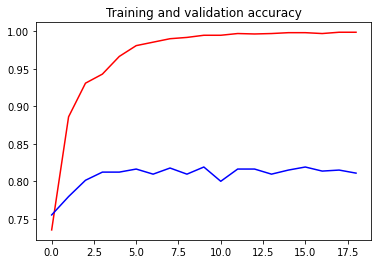

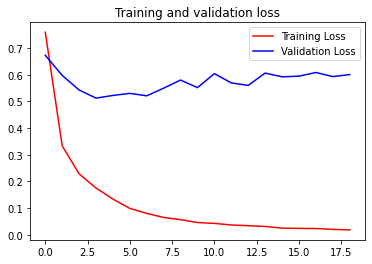

In [55]:
#Eğitim sürecinin görselleştirilmesi
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()